### 1. Text preprocessing

Load initial data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!cp drive/MyDrive/mipt_deep/nlp/handout.tar ./handout.tar
!tar -xvf handout.tar

data/
data/captions_tokenized.json
data/image_codes.npy


In [ ]:
import numpy as np
import json

img_codes = np.load("data/image_codes.npy")
captions = json.load(open('data/captions_tokenized.json'))

In [ ]:
print("Each image code is a 2048-unit vector [ shape: %s ]" % str(img_codes.shape))
print(img_codes[0,:10], end='\n\n')
print("For each image there are 5 reference captions, e.g.:\n")
print('\n'.join(captions[0]))

Each image code is a 2048-unit vector [ shape: (118287, 2048) ]
[0.3659946  0.2016555  0.9245725  0.57063824 0.547268   0.8275868
 0.3687277  0.12085301 0.0561931  0.49758485]

For each image there are 5 reference captions, e.g.:

people shopping in an open market for vegetables .
an open market full of people and piles of vegetables .
people are shopping at an open air produce market .
large piles of carrots and potatoes at a crowded outdoor market .
people shop for vegetables like carrots and potatoes at an open air market .


In [ ]:
len(captions)

118287

Create vocab to filter out rare words:

In [ ]:
from collections import Counter
import re

non_punct = re.compile('.*[A-Za-z0-9].*')

In [ ]:
counts = Counter()
filtered = [
            w for capt in captions
            for c in capt
            for w in c.split(' ') if non_punct.match(w)
            ]
word_counts = Counter(filtered)

len(word_counts.keys())

29383

In [ ]:
word_counts_filt = {w: word_counts[w] for w in word_counts.keys() if word_counts[w] > 5}

len(word_counts_filt.keys())

9485

In [ ]:
sorted(word_counts_filt.items(), key=lambda x: x[1], reverse=True)[:20]

[('a', 978125),
 ('on', 215537),
 ('of', 203940),
 ('the', 197668),
 ('in', 183933),
 ('with', 154705),
 ('and', 140709),
 ('is', 98138),
 ('man', 72984),
 ('to', 68106),
 ('sitting', 52880),
 ('an', 49848),
 ('two', 48320),
 ('at', 42703),
 ('standing', 42450),
 ('people', 41895),
 ('are', 41060),
 ('next', 37196),
 ('white', 36171),
 ('woman', 33934)]

In [ ]:
all_words = sorted(list(word_counts_filt.keys()))

In [ ]:
vocab = {w: (all_words.index(w)+1) for w in all_words}

Add custom tokens:

In [ ]:
vocab['<PAD>'] = 0
vocab['<BOS>'] = len(vocab.keys()) + 1
vocab['<EOS>'] = len(vocab.keys()) + 1

Split dataset into train, val, and test:

In [ ]:
from sklearn.model_selection import train_test_split
import numpy as np

train_idx, test_idx = train_test_split(np.arange(len(captions)), test_size=0.2, random_state=42)
val_idx, test_idx = train_test_split(test_idx, test_size=0.2, random_state=42)
train_idx.shape, val_idx.shape, test_idx.shape

((94629,), (18926,), (4732,))

#### Dataset class:

In [ ]:
import torch

class CaptionDataset(torch.utils.data.Dataset):
    def __init__(
        self, img_data, label_data,
        vocab=None, max_length=16,
        ):
        self.img_data = img_data
        self.label_data = label_data
        self.max_length = max_length
        self.vocab = vocab

        
    def __getitem__(self, idx):
        """
        Return dict with image_vector, label, and label index
        """
        img_vector = self.img_data[idx]
        label = self.label_data[idx]
        num_labels = len(label)
        label_idx = np.random.randint(0, num_labels-1)
        text = '<BOS> ' + label[label_idx] + ' <EOS>'
        non_punct = re.compile('.*[A-Za-z0-9].*')
        text = np.array([
                         self.vocab[c] for c in text.split(' ')
                         if non_punct.match(c) and c in self.vocab.keys()
                         ])
        length = text.shape[0]
        if length >= self.max_length:
            text = text[:self.max_length]
            text[-1] = self.vocab['<EOS>']
        else:
            text = np.pad(text, (0, self.max_length-length), 'constant')

        return {
            "image_vector": img_vector,
            "image_label": text, 
            "label_idx": label_idx,
        }
        
    def __len__(self):
        """
        Return length of dataset
        """
        return len(self.img_data)

Check out the captions lengths distribution:

In [ ]:
lens = [len(c.split(' ')) for capt in captions for c in capt]

In [ ]:
np.mean(lens), np.median(lens)

(11.292219770558049, 11.0)

^ ok, lets take 12

In [ ]:
train_captions = [captions[idx] for idx in train_idx]
valid_captions = [captions[idx] for idx in val_idx]
test_captions = [captions[idx] for idx in test_idx]

In [ ]:
train_img = img_codes[train_idx]
val_img = img_codes[val_idx]
test_img = img_codes[test_idx]

In [ ]:
MAX_LEN = 12

train_dataset = CaptionDataset(train_img, train_captions, vocab, MAX_LEN)
val_dataset = CaptionDataset(val_img, valid_captions, vocab, MAX_LEN)
test_dataset = CaptionDataset(test_img, test_captions, vocab, MAX_LEN)

In [ ]:
BATCH_SIZE = 256

train_loader = torch.utils.data.DataLoader(
    batch_size=BATCH_SIZE,
    dataset=train_dataset,
    shuffle=True,
    num_workers=4,
)

val_loader = torch.utils.data.DataLoader(
    batch_size=BATCH_SIZE,
    dataset=val_dataset,
    shuffle=False,
    num_workers=4,
)

test_loader = torch.utils.data.DataLoader(
    batch_size=BATCH_SIZE,
    dataset=test_dataset,
    shuffle=False,
    num_workers=4,
)

 ### 2. RNN captioning


In [ ]:
import torch, torch.nn as nn
import torch.nn.functional as F

In [ ]:
len(vocab.keys()) 

9488

In [ ]:
n_tokens = len(vocab.keys()) + 1

In [127]:
class CaptionNet(nn.Module):
    def __init__(
        self, n_tokens=n_tokens, emb_size=256, lstm_units=256,
        cnn_feature_size=2048, dropout=0.5
        )
        super(self.__class__, self).__init__()
        
        self.cnn_to_emb = nn.Linear(cnn_feature_size, emb_size)
        self.emb = nn.Embedding(n_tokens, emb_size)
        self.lstm = nn.LSTM(2*emb_size, lstm_units, batch_first=True)
        self.dropout = nn.Dropout(dropout)
        self.logits = nn.Linear(lstm_units, n_tokens)
        
    def forward(self, image_vectors, captions_ix):
        sent_len = captions_ix.shape[1]
        # linear layer from cnn to emb size, then copy sent_len times
        cnn_emb = self.cnn_to_emb(image_vectors).unsqueeze(1).repeat(1, sent_len, 1)
        captions_emb = self.emb(captions_ix)
        # concat and dropout
        captions_emb = self.dropout(torch.cat([captions_emb, cnn_emb], axis=2))
        # turns out that it's better to concat captions and cnn than to
        # pass cnn as hidden/cell
        lstm_out, (hn, cn) = self.lstm(captions_emb)

        logits = self.logits(lstm_out)
        
        return logits

In [128]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

network = CaptionNet().to(device)

In [136]:
def compute_loss(network, image_vectors, image_label):
    """
    :param image_vectors: torch tensor c выходами inception. shape: [batch, cnn_feature_size]
    :param image_label: torch tensor с описаниями (в виде матрицы). shape: [batch, word_i]. 
    
    :returns: scalar crossentropy loss (neg log likelihood) for next image_label given previous ones
    """
    
    preds = network(image_vectors.to(device), image_label.to(device).squeeze(1))
    preds = preds.permute(0, 2, 1).cpu()
    
    loss = nn.CrossEntropyLoss(ignore_index=0)
    
    return loss(preds, image_label.roll(-1, 1))

Inverse vocabulary:

In [138]:
inv_vocab = {vocab[w]: w for w in vocab.keys()}

## Train it

In [ ]:
lr = 1e-3

optimizer = torch.optim.AdamW(network.parameters(), lr=lr)

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, 'min', factor=0.75, verbose=True, patience=2
    )

In [ ]:
import time

def train(model, iterator, optimizer, clip, train_history=None, valid_history=None):
    model.train()
    epoch_loss = 0
    history = []
    for i, batch in enumerate(iterator):
        loss = compute_loss(model, batch['image_vector'], batch['image_label'])
        optimizer.zero_grad()
        loss.backward()
        # Let's clip the gradient
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)

        optimizer.step()
        epoch_loss += loss.item()

        history.append(loss.cpu().data.numpy())
        if (i+1)%10==0:
            fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 8))

            clear_output(True)
            ax[0].plot(history, label='train loss')
            ax[0].set_xlabel('Batch')
            ax[0].set_title('Train loss')
            if train_history is not None:
                ax[1].plot(train_history, label='general train history')
                ax[1].set_xlabel('Epoch')
            if valid_history is not None:
                ax[1].plot(valid_history, label='general valid history')
            plt.legend()
            
            plt.show()

        
    return epoch_loss / len(iterator)

def evaluate(model, iterator):
    
    model.eval()
    epoch_loss = 0
    history = []
    
    with torch.no_grad():
        for i, batch in enumerate(iterator):
            loss = compute_loss(model, batch['image_vector'], batch['image_label'])
            epoch_loss += loss.item()
        
    return epoch_loss / len(iterator)

def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

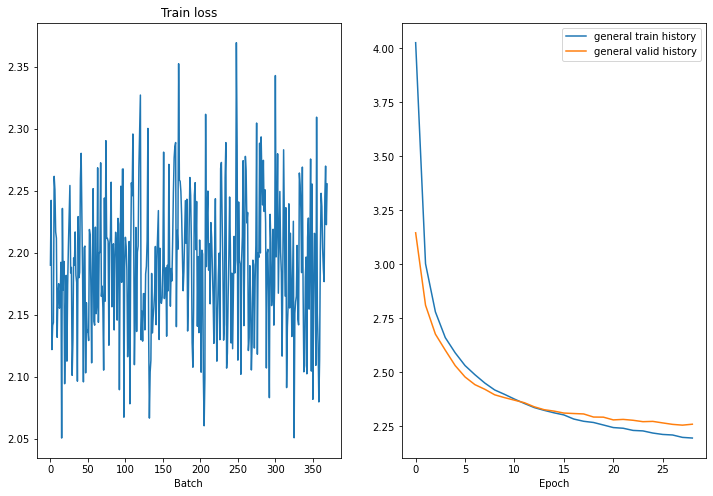

Epoch: 30 | Time: 3m 6s
	Train Loss: 2.190 | Train PPL:   8.936
	 Val. Loss: 2.254 |  Val. PPL:   9.524


In [ ]:
import matplotlib
matplotlib.rcParams.update({'figure.figsize': (16, 12), 'font.size': 14})
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import clear_output

train_history = []
valid_history = []

N_EPOCHS = 30
CLIP = 1

best_valid_loss = float('inf')

for epoch in range(N_EPOCHS):
    
    start_time = time.time()
    train_loss = train(
        network, train_loader, optimizer, CLIP,
        train_history, valid_history
        )
    valid_loss = evaluate(network, val_loader)
    scheduler.step(valid_loss)
    
    end_time = time.time()
    
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(network.state_dict(), 'best-val-model.pt')
    
    train_history.append(train_loss)
    valid_history.append(valid_loss)
    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {np.exp(train_loss):7.3f}')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {np.exp(valid_loss):7.3f}')

In [ ]:
# !cp best-val-model.pt drive/MyDrive/mipt_deep/nlp/final_hw/0902_copy12.pt

In [ ]:
# !cp drive/MyDrive/mipt_deep/nlp/final_hw/0902_copy12.pt best-val-model.pt

In [4]:
network.load_state_dict(torch.load('best-val-model.pt'))
network.eval()

In [2]:
import torchvision.models as models

inception = models.inception_v3(pretrained=True)

inception.eval()
inception.fc = nn.Identity()

In [90]:
from scipy.special import softmax

In [144]:
def generate_caption(image, caption_prefix=('<BOS>',), 
                     t=1, sample=True, max_len=16):
    assert isinstance(image, np.ndarray) and np.max(image) <= 1\
           and np.min(image) >=0 and image.shape[-1] == 3
    
    with torch.no_grad():
        image = torch.tensor(image.transpose([2, 0, 1]), dtype=torch.float32)

        image_vectors = inception(image.unsqueeze(0))
        caption_prefix = list(caption_prefix)

        for _ in range(max_len):
            logits = network(
                image_vectors.to(device),
                torch.tensor([
                              vocab[c] for c in caption_prefix
                              ]).to(device).unsqueeze(0)
                              )
            logits = logits.detach().cpu().numpy()
            
            new_word = inv_vocab[np.argmax(logits[:, -1, :])]
            if sample:
                probs = softmax(logits[:, -1, :][0])
                new_word = inv_vocab[np.random.choice(
                  range(len(inv_vocab.keys())+1), 1, p=probs
                  ).item()]
            
            caption_prefix += [new_word]
            if new_word == '<EOS>':
                break
        
    return caption_prefix

In [145]:
from PIL import Image

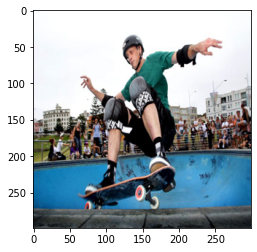

a man riding a skateboard on a rail

a skateboarder jumps on a tree at the park
a boy with no excitedly holds a skateboard on a
a skateboarder doing a trick on a skateboard in the
a boy doing a kickflip while doing tricks in the
a young man riding a skateboard up the side of
a skateboarder is on a rail road jumping on a
there is a male here is airborne in the crowd
a young man flipping the after talking on a coaster
a skateboarder balances on his skate board does stunts while
a man is sliding across a skateboard in the air


In [146]:
from matplotlib import pyplot as plt
%matplotlib inline

#sample image
!wget -q https://pixel.nymag.com/imgs/daily/selectall/2018/02/12/12-tony-hawk.w710.h473.jpg -O img.jpg
img = plt.imread('img.jpg')
img = np.array(Image.fromarray(img).resize((299, 299))).astype('float32') / 255.

plt.imshow(img)
plt.show()

print(' '.join(generate_caption(img, t=5., sample=False)[1:-1]))
print('')
for i in range(10):
    print(' '.join(generate_caption(img, t=5.)[1:-1]))

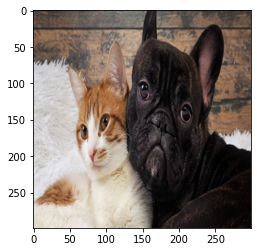

a cat laying on a bed with a toy

an orange cat is looking at his feet
a dog licking peacefully of its paw out of his
an adorable kitten licks its eyes laying on top of
an orange cat hat is relaxing on a pillow
a dog and an owl are standing in a garage
a cat wearing paints on a camouflaged leash
a black and white dog and a dog lying near a
a cat laying on its back on a couch
a black and white cat sitting on a pile of
a black and white cat is resting on a pillow


In [147]:
!wget -q http://ccanimalclinic.com/wp-content/uploads/2017/07/Cat-and-dog-1.jpg -O img.jpg
img = plt.imread('img.jpg')
img = np.array(Image.fromarray(img).resize((299, 299))).astype('float32') / 255.

plt.imshow(img)
plt.show()

print(' '.join(generate_caption(img, t=5., sample=False)[1:-1]))
print('')
for i in range(10):
    print(' '.join(generate_caption(img, t=5.)[1:-1]))

# Demo

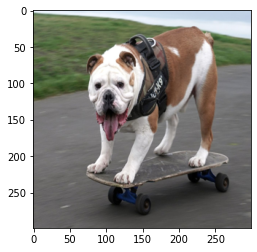

a dog is sitting on a skateboard on the ground

person with crazy hat on a leash in a skateboard
two monkeys ducklings walking the ground and a fire hydrant
a bulldog outside trying to hit a ball with a
two dogs are standing on buns against the sidewalk
a black and white bulldog resting on top of a
a bulldog is sitting outdoors and others on a fire
two dogs are chained to catch a frisbee in a
a brown curly white dog on a leash
a cat is laying on a tennis that is walking
a dog that is laying down on the floor in


In [148]:
!wget -q https://i2-prod.chroniclelive.co.uk/incoming/article17659209.ece/ALTERNATES/s1200b/0_British-bulldog-rides-skateboard.jpg -O img.jpg
img = plt.imread('img.jpg')
img = np.array(Image.fromarray(img).resize((299, 299))).astype('float32') / 255.

plt.imshow(img)
plt.show()

print(' '.join(generate_caption(img, t=5., sample=False)[1:-1]))
print('')
for i in range(10):
    print(' '.join(generate_caption(img, t=5.)[1:-1]))

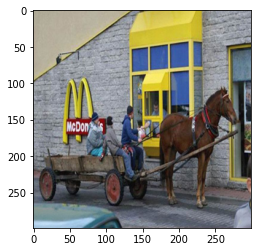

a horse drawn carriage pulling a carriage on a city

a man riding a horse drawn carriage in parking lot
a horse pulling a wagon with supplies pulled up
a horse pulling a carriage with people on a city
a horse drawn carriage down a mule area with a
a horse carriage has parked on the road
a person on a horse guiding a carriage on a
man horse riding in rounds wearing carriage
a horse pulling a cart on top of a large
clydesdale horse drawn carriage pulling carriage along a path
a horse drawn carriage with a horse circles by it


In [149]:
!wget -q https://wl-brightside.cf.tsp.li/resize/728x/jpg/fb0/bb7/20e16255f78dfb625ba0ff426e.jpg -O img.jpg
img = plt.imread('img.jpg')
img = np.array(Image.fromarray(img).resize((299, 299))).astype('float32') / 255.

plt.imshow(img)
plt.show()

print(' '.join(generate_caption(img, t=5., sample=False)[1:-1]))
print('')
for i in range(10):
    print(' '.join(generate_caption(img, t=5.)[1:-1]))

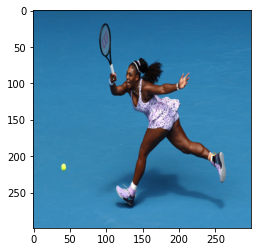

a woman holding a tennis racquet on a tennis court

a female tennis player swings her racket with her racquet
a young woman playing tennis and a blue skirt
a female tennis player swinging a racket on the court
a girl are with a racket in her hand in
a woman hitting a tennis ball on the court
a woman holding a tennis racquet in her tennis racquet
a girl is flipped outside above the tennis rink
a woman standing in a tennis court holding a racquet
a young woman holding a tennis racket in a tennis game
several people are holding white tennis racket jumping to a


In [150]:
!wget -q https://hips.hearstapps.com/hmg-prod.s3.amazonaws.com/images/serena-williams-of-the-united-states-plays-a-forehand-news-photo-1599160172.jpg -O img.jpg

img = plt.imread('img.jpg')
img = np.array(Image.fromarray(img).resize((299, 299))).astype('float32') / 255.

plt.imshow(img)
plt.show()

print(' '.join(generate_caption(img, t=5., sample=False)[1:-1]))
print('')
for i in range(10):
    print(' '.join(generate_caption(img, t=5.)[1:-1]))

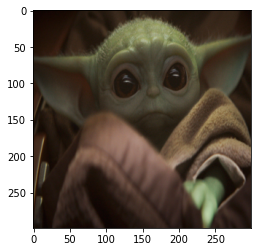

a small child is sitting on a bed

player wearing headphones and taking a red bow bag
the man is sitting next to his stuffed bear
a teddy bear sitting on a metal screen
a child holding a remote control and wearing ties
a bulldog wearing a backpack holding up a banana
this is a picture of someones teddy bear hugging
a pink stuffed teddy bear tucked up on a teddy
a covered bed wearing asian clothes and a chairs
scenery with a laid stuffed animal attached to shop
a mix of some bananas sitting on top of a


In [156]:
!wget -q https://www.nme.com/wp-content/uploads/2019/12/2AA3JDC.jpg -O img.jpg

img = plt.imread('img.jpg')
img = np.array(Image.fromarray(img).resize((299, 299))).astype('float32') / 255.

plt.imshow(img)
plt.show()

print(' '.join(generate_caption(img, t=5., sample=False)[1:-1]))
print('')
for i in range(10):
    print(' '.join(generate_caption(img, t=5.)[1:-1]))